# Teste do modelo Naive Bayes
Neste notebook, um modelo Naive Bayes será criado e terá seus hiperparâmetros otimizados a fim de prever a classe de um indivíduo (Control ou Impaired) de acordo com seus biomarcadores. O modelo NaiveBayes é baseado no Teorema de Bayes para calcular a probabilidade de uma amostra pertencer a uma determinada classe dados os seus atributos considerando que não há interdependência entre pares de atributos (essa consideração pode estar errada, por isso Bayes Ingênuo).

Como nosso conjunto de treino é formado praticamente apenas por dados numéricos, foi utilizado o NaiveBayes Gaussiano, que assume que a probabilidade das características segue uma distribuição gaussiana.

A métrica usada para selecionar os atributos e otimizar o único hiperparâmetro do modelo será a sensitividade.

## Importando dados

In [37]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Importando dados:
Aqui os dados serão importados e devidamente manipulados. Como consequência da exportação dos arquivos csv feita pelo código do tratamento geral, surge uma coluna que carrega os índices de cada fileira. Como não queremos que esta interfira em qualquer procedimento de nosso modelo, vamos excluí-la. 

Como nosso target é categórico binário, devemos codificá-lo em 0 e 1 para que nosso modelo funcione. O valor 'Control' será codificado como 0 e o valor 'Impaired' será codificado como 1.

In [38]:
# Importando dados
features = pd.read_csv("Features para treino.csv")
X_treino = features.drop("Unnamed: 0", axis=1).values

target = pd.read_csv("Target para treino.csv")
target = target["Class"]

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1)
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [39]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

## Seleção de atributos:
Nesta parte do código, executaremos a seleção de atributos de nossas features. Utilizaremos o algoritmo de Seleção Sequencial de Atributos, que calcula a importância de cada coluna para o resultado do modelo e retira as colunas que não são interessantes para análise. 

In [40]:
#Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = GaussianNB()
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="recall",
    cv = 5,
    n_jobs=-1
)
seletor.fit(X_treino, target)

X_treino = seletor.transform(X_treino)
X_teste = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")


Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True False  True  True False False False False False False False  True
 False False False False  True False False False  True False  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


## Otimização de hiperparâmetros:
Nesta parte do código, otimizamos os hiperparâmetros do modelo GaussianNB do Sci-Kit Learn utilizando o Optuna, que permite uma otimização inteligente dos hiperparâmetros de um modelo. Para isso, foram criadas as funções de instância, objetivo e objetivo parcial a fim de que sejam utilizadas no estudo do optuna. Como há apenas um hiperparâmetro a ser calculado, não há necessidade de um grande número de trials.

A suavização de variância (var_smoothing) do GaussianNB é um hiperparâmetro que regulariza o conjunto de dados a fim de evitar o surgimento de variâncias muito pequenas (ou nulas) durante o cálculo do modelo. O surgimento destas condições pode levar a divisões por zero e erros durante o funcionamento do modelo.

In [41]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="recall",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_nb(trial):
    parametros = {"var_smoothing": trial.suggest_float("var_smoothing", 1e-11, 1e-1, log=True)}
    return objetivo_geral(trial, parametros, GaussianNB)

In [42]:
NOME_DO_ESTUDO = "naive_bayes2"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_nb, n_trials=100)

[I 2025-11-03 02:40:36,384] Using an existing study with name 'naive_bayes2' instead of creating a new one.
[I 2025-11-03 02:40:36,490] Trial 200 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 4.209969765950586e-11}. Best is trial 3 with value: 0.7065934065934065.
[I 2025-11-03 02:40:36,558] Trial 201 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 9.046189270937905e-11}. Best is trial 3 with value: 0.7065934065934065.
[I 2025-11-03 02:40:36,622] Trial 202 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 5.89573941439312e-11}. Best is trial 3 with value: 0.7065934065934065.
[I 2025-11-03 02:40:36,705] Trial 203 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 2.3827088297954734e-11}. Best is trial 3 with value: 0.7065934065934065.
[I 2025-11-03 02:40:36,774] Trial 204 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 3.6331264627639786e-11}. Best is trial 3 wit

## Execução e validação cruzada do modelo: 
Aqui, será instanciado um modelo GaussianNB com os hiperparâmetros selecionados pelo Optuna. O modelo será treinado com os conjuntos de dados de treino e em seguida, será testado com os dados de teste. 

Primeiro, será calculada a acurácia do modelo, em seguida, será feita uma validação cruzada para estimar a sensitividade do modelo.

In [50]:
params = estudo_knn.best_trial.params

predictor = GaussianNB(**params)
predictor.fit(X_treino, target)
predicoes = predictor.predict(X_teste)

accuracy = accuracy_score(y_teste, predicoes)
print(accuracy)

y_pred_trans = le.inverse_transform(predicoes)

medida = cross_val_score(predictor, X_teste, y_teste, scoring="recall", cv=5)
print("Recall médio no conjunto de teste:", medida.mean())

0.8214285714285714
Recall médio no conjunto de teste: 0.54


<Axes: >

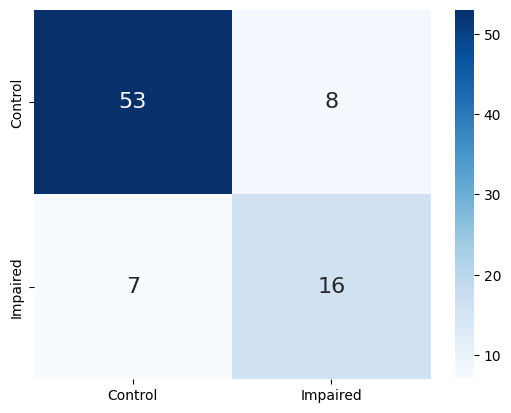

In [44]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [45]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.88      0.87      0.88        61
    Impaired       0.67      0.70      0.68        23

    accuracy                           0.82        84
   macro avg       0.77      0.78      0.78        84
weighted avg       0.82      0.82      0.82        84



## Resultados e conclusão:
O modelo apresenta acurácia de 0.82. Considerando que temos um conjunto de dados de treino pequeno, podemos dizer que é um resultado consideravelmente bom. 

A previsão de indivíduos doentes teve uma previsão de 0.67 e uma sensitividade de 0.7. Nosso conjunto de dados de teste é pequeno e desbalanceado, o que dificulta a medida de desempenho do modelo. Apesar de errar "pouco", a quantidade de erros cometidos é proporcionalmente muito grande.

Analisando o recall médio da validação cruzada, nossa perspectiva piora: temos um recall médio de 0.54, ou seja, nosso modelo é quase tão confiável quanto atirar uma moeda. Em resumo, o modelo NaiveBayes não é indicado para o fim buscado neste notebook.